# Meta Learning Tutorial with the Sinusoid Regression Dataset

In [19]:
import functools

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import optax

import haiku as hk

from tensorflow_probability.substrates import jax as tfp

import sinusoid_regression_dataset
import maml
import nets

tfd = tfp.distributions

## Explore the dataset a bit

Plotting and exploration based on https://github.com/ericjang/maml-jax/blob/master/maml.ipynb

In [20]:
num_shots = 50
sinusoid = sinusoid_regression_dataset.SinusoidRegression(4, num_shots)

In [21]:
def plot_example(support, query):
    plt.figure(figsize=(16, 10))
    plt.scatter(support[0], support[1], label='Support set')
    plt.scatter(query[0], query[1], label='Query set')
    plt.legend()

Plot a batch of the support and query sets.

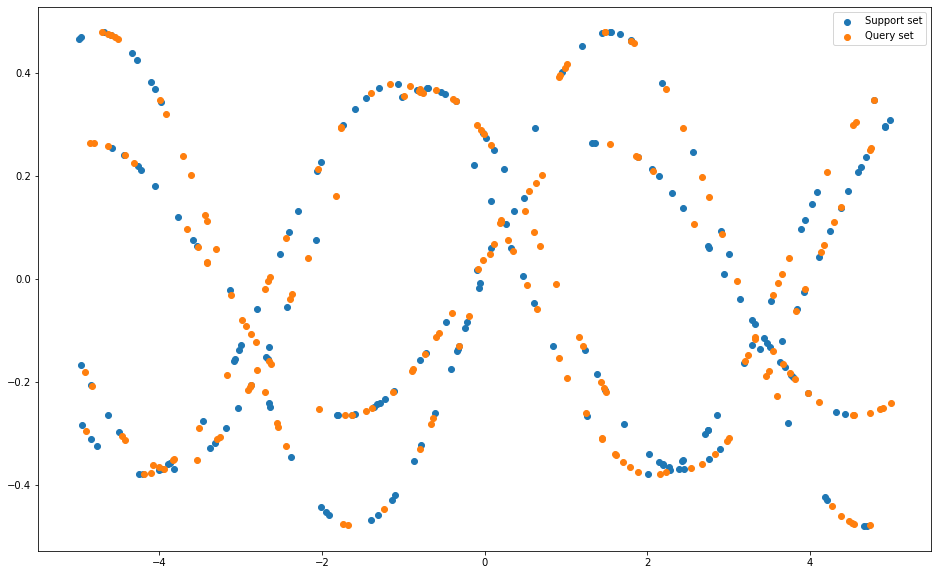

In [4]:
support, query = next(sinusoid.train_set)
plot_example(support, query)

## Defining a training loop

In [28]:
@functools.partial(jax.jit, static_argnums=[0, 1])
def update(model, opt, prior_params, opt_state, support, query):
    grads = model.update_step(prior_params, support, query)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(prior_params, updates)
    return new_params, new_opt_state

def predict_eval(model, params, x, y):
    dist = model(params, x)
    return dist.mode(), dist.log_prob(y)

predict_eval = jax.vmap(predict_eval, in_axes=[None, 0, 0, 0])

def train(model, data, lr=0.001, steps=1000):
    eval_losses = []
    opt = optax.flatten(optax.adam(lr))
    opt_state = opt.init(model.prior_params)
    for step in range(steps):
        model.prior_params, opt_state = update(model, opt, model.prior_params, opt_state, *next(data.train_set))
        if step % 1000 == 0:
            eval_support, eval_query = next(data.eval_set)
            posterior_params = model.adaptation_step(model.prior_params, *eval_support)
            pred, eval_ = predict_eval(model, posterior_params, *eval_query)
            eval_loss = -eval_.mean()
            eval_mse = ((pred - eval_query[1]) ** 2).sum(axis=-1).mean()
            eval_losses.append(eval_loss)
            print('Training step: {} -- loss: {:.4f} -- mse: {:.4f}'.format(step, eval_loss, eval_mse))
    return eval_losses
            


## Train MAML

In [29]:
def net(x):
    x = nets.mlp(x)
    dist = tfd.Independent(tfd.Normal(x, 1.), 1)
    return dist

model = maml.Maml(net, support[0][0], 0.1, adaptation_steps=1)
train(model, sinusoid, 1e-2, steps=20000)

Training step: 0 -- loss: 0.9372 -- mse: 0.0365
Training step: 1000 -- loss: 0.9215 -- mse: 0.0051
Training step: 2000 -- loss: 0.9206 -- mse: 0.0034
Training step: 3000 -- loss: 0.9207 -- mse: 0.0035
Training step: 4000 -- loss: 0.9207 -- mse: 0.0036
Training step: 5000 -- loss: 0.9199 -- mse: 0.0019
Training step: 6000 -- loss: 0.9205 -- mse: 0.0031
Training step: 7000 -- loss: 0.9197 -- mse: 0.0015
Training step: 8000 -- loss: 0.9205 -- mse: 0.0032
Training step: 9000 -- loss: 0.9220 -- mse: 0.0062
Training step: 10000 -- loss: 0.9203 -- mse: 0.0027
Training step: 11000 -- loss: 0.9210 -- mse: 0.0041
Training step: 12000 -- loss: 0.9209 -- mse: 0.0040
Training step: 13000 -- loss: 0.9205 -- mse: 0.0031
Training step: 14000 -- loss: 0.9197 -- mse: 0.0014
Training step: 15000 -- loss: 0.9205 -- mse: 0.0032
Training step: 16000 -- loss: 0.9210 -- mse: 0.0041
Training step: 17000 -- loss: 0.9197 -- mse: 0.0016
Training step: 18000 -- loss: 0.9202 -- mse: 0.0025
Training step: 19000 -- l

[DeviceArray(0.93716633, dtype=float32),
 DeviceArray(0.92147094, dtype=float32),
 DeviceArray(0.9206149, dtype=float32),
 DeviceArray(0.92068833, dtype=float32),
 DeviceArray(0.920741, dtype=float32),
 DeviceArray(0.9198747, dtype=float32),
 DeviceArray(0.9204791, dtype=float32),
 DeviceArray(0.91970885, dtype=float32),
 DeviceArray(0.9205255, dtype=float32),
 DeviceArray(0.9220165, dtype=float32),
 DeviceArray(0.9202683, dtype=float32),
 DeviceArray(0.92098767, dtype=float32),
 DeviceArray(0.92093146, dtype=float32),
 DeviceArray(0.92050934, dtype=float32),
 DeviceArray(0.9196569, dtype=float32),
 DeviceArray(0.92053694, dtype=float32),
 DeviceArray(0.9209753, dtype=float32),
 DeviceArray(0.9197328, dtype=float32),
 DeviceArray(0.9201997, dtype=float32),
 DeviceArray(0.9197103, dtype=float32)]

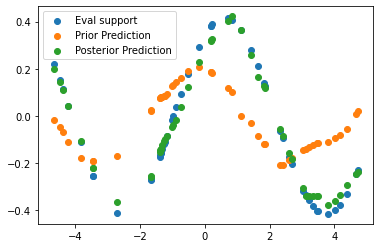

In [30]:
eval_support, eval_query = next(sinusoid.eval_set)
pred = model(model.prior_params, eval_query[0]).mode()
plt.scatter(eval_query[0][0], eval_query[1][0], label='Eval support')
plt.scatter(eval_query[0][0], pred[0], label='Prior Prediction')
                      
posterior_params = model.adaptation_step(model.prior_params, *eval_support)
pred, _ = predict_eval(model, posterior_params, *eval_query)

plt.scatter(eval_query[0][0], pred[0], label='Posterior Prediction')
plt.legend()